# Implemntation of GRU neural networks on predicting tadawul market 
### By Abdullah omran ; abdullahomran9@gmail.com

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding ,LSTM
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Check Tensorflow version . 

In [3]:
tf.__version__


'1.12.0'

Prepare the data you have , for ex. this data was fetch by my tadawul scraper , you can check my github account . 

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv(r"C:\Users\abdullah\Documents\Python notebook\tadawul\four.csv", parse_dates=['Date'],
                   index_col='Date',date_parser=dateparse)
data['T-Open'] = [x.replace(',', '') for x in data['T-Open']]
data['T-Open']=data['T-Open'].astype(float)
data.head()


,Open,High,Low,T-Open
Date,,,,
2012-04-25,69.50,70.00,68.75,7512.26
2012-04-28,70.00,70.50,69.00,7541.50
2012-04-29,70.25,73.25,69.25,7607.59
2012-04-30,72.25,72.25,69.50,7555.77
2012-05-01,69.50,70.25,69.00,7558.47


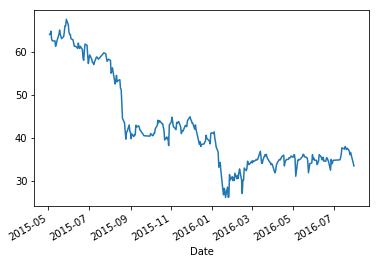

In [5]:
data['Open']['2015-05':'2016-07'].plot()

In [6]:
x_data = data.values

In [7]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (1680, 4)


In [8]:
shift_days = 1
shift_steps = shift_days * 5  # Number of hours.

df_targets = data[['Open','High']].shift(-shift_steps)
data[['Open','High']].head(shift_steps + 5)

,Open,High
Date,,
2012-04-25,69.50,70.00
2012-04-28,70.00,70.50
2012-04-29,70.25,73.25
2012-04-30,72.25,72.25
2012-05-01,69.50,70.25
2012-05-02,70.00,71.00
2012-05-05,69.00,69.75
2012-05-06,69.00,69.25
2012-05-07,68.25,68.50


In [9]:
target_names = ['Open','High']

In [10]:
data.tail()

,Open,High,Low,T-Open
Date,,,,
2019-01-15,43.80,44.45,43.4,8270.55
2019-01-16,43.95,44.10,43.3,8347.25
2019-01-17,43.50,43.70,43.2,8406.47
2019-01-20,43.60,43.70,43.0,8448.02
2019-01-21,43.25,43.40,42.7,8383.52


In [11]:
x_data = data.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (1675, 4)


In [12]:
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (1675, 2)


In [13]:

num_data = len(x_data)
num_data

1675

In [14]:
train_split = 0.9
num_train = int(train_split * num_data)
print(num_train)
num_test = num_data - num_train
print(num_test)

1507
168


In [15]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

1675

In [84]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

1675

In [85]:
num_x_signals = x_data.shape[1]
num_x_signals

4

In [191]:
num_y_signals = y_data.shape[1]
num_y_signals

2

In [192]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 21.05
Max: 11149.36


In [193]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [194]:
x_test_scaled = x_scaler.transform(x_test)

In [195]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [196]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(1507, 4)
(1507, 2)


In [197]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [198]:
batch_size = 3

In [199]:
sequence_length = 200
sequence_length

200

In [200]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [201]:
x_batch, y_batch = next(generator)

In [202]:
print(x_batch.shape)
print(y_batch.shape)

(3, 200, 4)
(3, 200, 2)


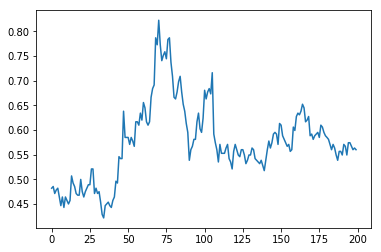

In [203]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

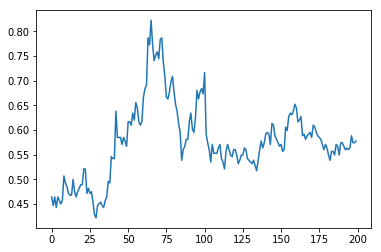

In [204]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [205]:

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [206]:
model = Sequential()
model.add(GRU(units=128,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))

In [235]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.0005, maxval=0.0005)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [236]:

warmup_steps = 2

In [237]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [238]:
optimizer = RMSprop(lr=0.001)


In [239]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)


In [240]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 128)         51072     
_________________________________________________________________
dense_3 (Dense)              (None, None, 2)           258       
Total params: 51,330
Trainable params: 51,330
Non-trainable params: 0
_________________________________________________________________


In [241]:
path_checkpoint = '24_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [242]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [243]:

callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [244]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.01,
                                       min_lr=0.001,
                                       patience=0,
                                       verbose=1)

In [245]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [246]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 00001: val_loss improved from inf to 0.00465, saving model to 24_checkpoint.keras
100/100 [==============================] - 8s 79ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 00002: val_loss improved from 0.00465 to 0.00340, saving model to 24_checkpoint.keras
100/100 [==============================] - 7s 72ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 00003: val_loss improved from 0.00340 to 0.00116, saving model to 24_checkpoint.keras
100/100 [==============================] - 7s 73ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 00004: val_loss did not improve from 0.00116

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.001.
100/100 [=========================

In [247]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 13ms/step


In [248]:
print("loss (test-set):", result)


loss (test-set): 0.0014099074760451913


In [249]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()


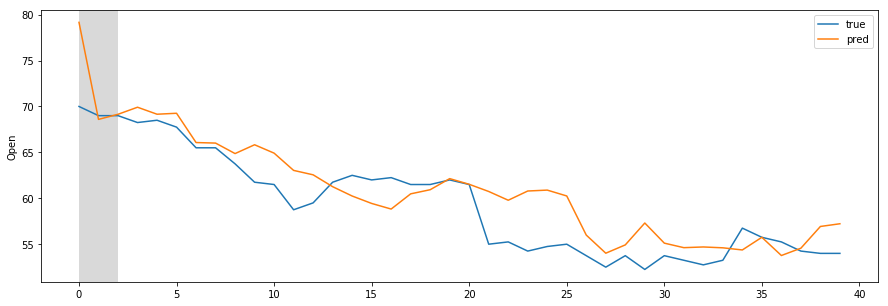

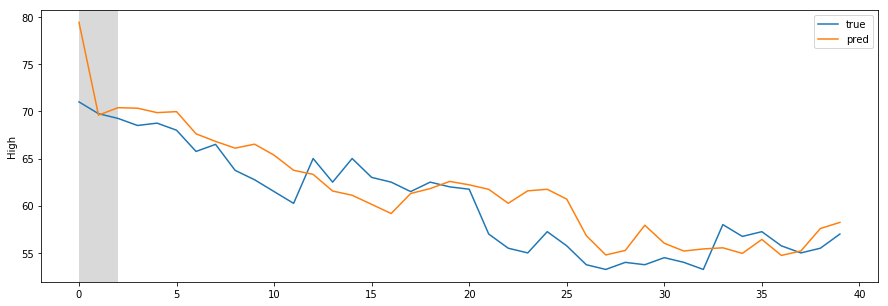

In [250]:
plot_comparison(start_idx=0, length=40, train=True)


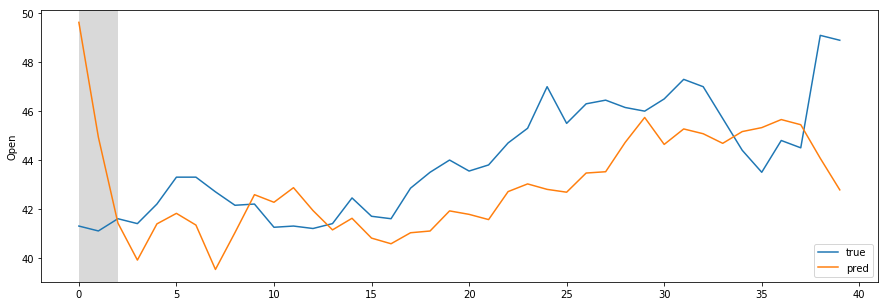

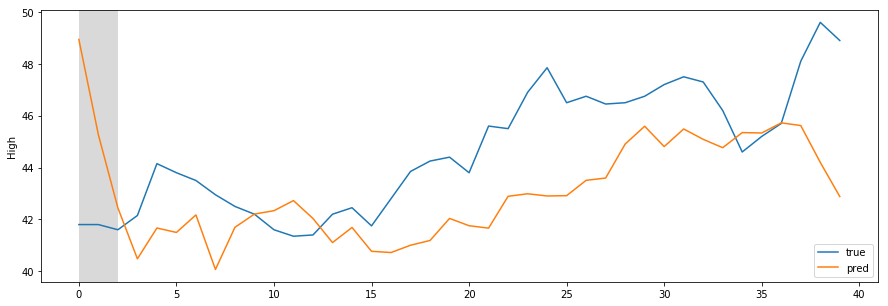

In [251]:
plot_comparison(start_idx=0, length=40, train=False)